[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://bit.ly/3SJewuO)

# Creating a Pipeline with LineaPy abc

**Table of Contents**

- [Intro](#Intro)
- [Demo](#Demo)
    - [Exploration and Pre-processing](#Exploration-and-Pre-processing)
    - [Modeling](#Modeling)
    - [Airflow Pipeline Building](#Airflow-Pipeline-Building)
    - [Running Airflow Pipelines Locally](#Running-Pipelines-Locally)
- [Additional Frameworks](#Additional-Frameworks)
    - [Argo](#Argo)
    - [Kubeflow](#Kubeflow)
    - [Ray](#Ray)
    - [DVC](#DVC)
- [Recap](#Recap)

## Intro

### Scenario

As notebooks become more mature, they may get used like pipelines. For instance, notebooks that do the following things:

* Process latest data and update dashboards/graphs/charts/reports
* Preprocess new data and dump it to the filesystem or database for downstream model development
* Create updated versions of models using latest data
* Run inference on new data using standard model

may be expected to be re-executed as a pipeline on a regular or ad-hoc basis.

However, you may not have the proper engineering support to set up these pipelines for production.

### What might happen next?

If this is the case, any of the following may happen:

* You spend a lot of time copying and pasting and cleaning your code to make your pipeline work in orchestration systems or job schedulers (cron, Apache Airflow, Prefect, etc.).
* It takes forever to make your pipeline work and you end up running your pipelines manually whenever you need to or get asked to.
* Your runtime environment is changed due to other experiments you are running and your pipeline is no longer working.
* You make some changes to your pipeline and now you find out you need to restart the above processes again.

As more notebooks and pipelines need to be maintained, data scientists will need to spend more time on the operation side to make sure every notebook is running at the right time successfully. 
This operational burden will consume a lot of time from the data scientist, which decreases productivity and innovation.

### How can LineaPy help here?

LineaPy can help to set up and maintain pipelines with minimal effort.

```
import lineapy

........................
.
. your original notebook
. 
........................

lineapy.save(object, 'artifact name')
lineapy.to_pipeline(['artifact name', 'other artifact name', ... ], framework, pipeline_name, output_dir)
```
 
With just these three lines of code, LineaPy enables data scientists to produce runnable pipelines.
For some orchestration systems, like Apache Airflow, LineaPy is even able to upload the runnable pipeline without any manual interaction.

The rest of this notebook will use a concrete example to walk you through how this can be done.

## Demo

<div class="admonition info" style="background:#F0FAFA">
    <p class="admonition-title"><b>Info</b></p>
    <p>
        If you encounter issues you cannot resolve, simply ask in our <a href="https://join.slack.com/t/lineacommunity/shared_invite/zt-18kizfn3b-1Qu_HDT3ahGudnAwoFAw9Q">Slack community</a>'s <code>#support</code> channel. We are always happy and ready to help you!
    </p>
</div>

<div class="admonition note" style="background:#F0F4FA">
    <p class="admonition-title"><b>Note</b></p>
    <p>
        You can ignore <code># NBVAL_*</code> comments in certain cell blocks. They are for passing unit tests only, which we do to make sure the examples are always functional as we update the codebase.
    </p>
</div>

In [1]:
#NBVAL_SKIP
%%capture
!pip -q install lineapy~=0.2 scikit-learn pandas matplotlib

In [2]:
#NBVAL_SKIP
%load_ext lineapy

The lineapy extension is already loaded. To reload it, use:
  %reload_ext lineapy


In [3]:
# NBVAL_IGNORE_OUTPUT

import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lineapy.tag("Pipeline End-to-End Demo")

### Exploration and Pre-processing

We are a botanist working in an ecology lab, and we recently obtained a data set to explore. Let's see what it contains.

In [4]:
# Load data
url = "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
df = pd.read_csv(url)

In [5]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


It is simple data that contains different iris species and their physical measurements. Our common sense dictates that petal length and width may have an association. Let's quickly check.

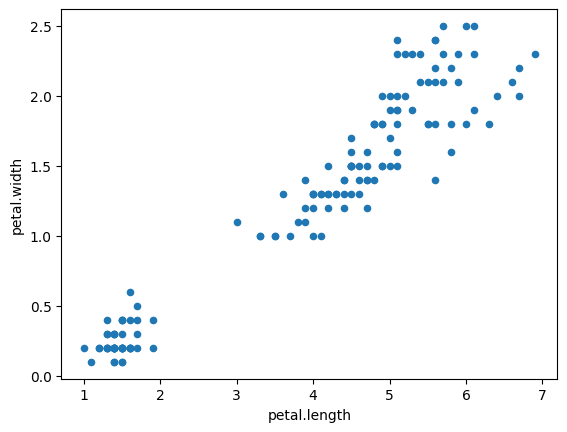

In [6]:
# NBVAL_IGNORE_OUTPUT

# Plot petal vs. sepal width
df.plot.scatter("petal.length", "petal.width")
plt.show()

We visually confirm that there is a strong positive relationship between petal length and width.

More interestingly, we see a distinct cluster of observations at the lower left side fof the plot, which suggests that these observations may correspond to a specific species. Let's plot observations by species.

In [7]:
# Check species and their counts
df["variety"].value_counts()

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

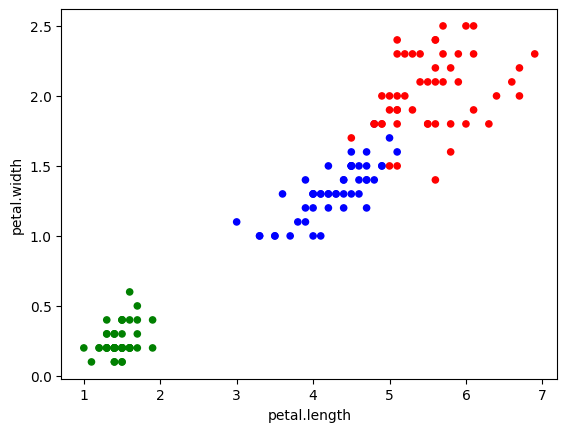

In [8]:
# NBVAL_IGNORE_OUTPUT

# Map each species to a color
color_map = {"Setosa": "green", "Versicolor": "blue", "Virginica": "red"}
df["variety_color"] = df["variety"].map(color_map)

# Plot petal length vs. width by species
df.plot.scatter("petal.length", "petal.width", c="variety_color")
plt.show()

We indeed confirm that each species forms a quite distinct cluster based on petal traits.

To make our analysis more interesting, let's try some formal modeling, where we will try to identify the species of a given iris based on its petal traits.

In [9]:
# For modeling, map each species to a number
num_map = {"Setosa": 0, "Versicolor": 1, "Virginica": 2}
df["variety_num"] = df["variety"].map(num_map)

In [10]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety,variety_color,variety_num
0,5.1,3.5,1.4,0.2,Setosa,green,0
1,4.9,3.0,1.4,0.2,Setosa,green,0
2,4.7,3.2,1.3,0.2,Setosa,green,0
3,4.6,3.1,1.5,0.2,Setosa,green,0
4,5.0,3.6,1.4,0.2,Setosa,green,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica,red,2
146,6.3,2.5,5.0,1.9,Virginica,red,2
147,6.5,3.0,5.2,2.0,Virginica,red,2
148,6.2,3.4,5.4,2.3,Virginica,red,2


Let's store the pre-processed data as an artifact since we may want to reuse/recompute it later.

In [11]:
# NBVAL_IGNORE_OUTPUT

# Save side effects as an artifact
lineapy.save(df, "iris_preprocessed")

LineaArtifact(name='iris_preprocessed', _version=1)

<div class="admonition info" style="background:#F0FAFA">
    <p class="admonition-title"><b>Info</b></p>
    <p>
        In LineaPy, an artifact is both code and value. That is, when storing an artifact, LineaPy not only records the state (i.e., value) of the variable but also traces and saves all relevant operations leading to this state &mdash; as code. Such a complete development history or *lineage* then allows LineaPy to fully reproduce the given artifact. Learn more about LineaPy artifacts <a href="https://docs.lineapy.org/latest/tutorials/01_using_artifacts/">here</a>.
    </p>
</div>

### Modeling

For model building and evaluation, we need to split the data into training and test sets.

In [12]:
# Identify predictor and outcome variables
X = df[["petal.length", "petal.width"]]
y = df["variety_num"]

# Specify parameters of data split
test_size = 0.33
random_state = 42

# Split the data
split_samples = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train = split_samples[0]
X_test = split_samples[1]
y_train = split_samples[2]
y_test = split_samples[3]

With the data split, we can now proceed to model training. Ours is a classification problem, so we can use multinomial logistic regression.

In [13]:
# NBVAL_IGNORE_OUTPUT

# Initiate the model
mod = LogisticRegression(multi_class="multinomial")

# Fit the model
mod.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Let's examine the model's accuracy, first on the training data and then on the test data.

In [14]:
# NBVAL_IGNORE_OUTPUT

# Examine model accuracy on training data
y_train_pred = mod.predict(X_train)
mod_eval_train = classification_report(y_train, y_train_pred, digits=3)
print(mod_eval_train)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        31
           1      0.941     0.914     0.928        35
           2      0.914     0.941     0.928        34

    accuracy                          0.950       100
   macro avg      0.952     0.952     0.952       100
weighted avg      0.950     0.950     0.950       100



In [15]:
# NBVAL_IGNORE_OUTPUT

# Examine model accuracy on test data
y_test_pred = mod.predict(X_test)
mod_eval_test = classification_report(y_test, y_test_pred, digits=3)
print(mod_eval_test)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        19
           1      1.000     1.000     1.000        15
           2      1.000     1.000     1.000        16

    accuracy                          1.000        50
   macro avg      1.000     1.000     1.000        50
weighted avg      1.000     1.000     1.000        50



Overall, results indicate our model is very accurate with all correct predictions on the test data!

We are quite content with the model, so let's save it as an artifact.

In [16]:
# NBVAL_IGNORE_OUTPUT

# Save the fitted model as an artifact
lineapy.save(mod, "iris_model")

LineaArtifact(name='iris_model', _version=1)

Let's also save the model evaluation result so we can reference it later as needed. For instance, this information may help model comparison and selection.

In [17]:
# NBVAL_IGNORE_OUTPUT

# Save the model evaluation result as an artifact
lineapy.save(mod_eval_test, "iris_model_evaluation")

LineaArtifact(name='iris_model_evaluation', _version=1)

### Airflow Pipeline Building

Say we expect rerunning the above processes again in the future. For instance, our source data (`iris.csv`) may get new observations added. Or, we may want to train the model with a different source data. Or, we may want to train the model with a different randomization setup (i.e., different `random_state`). For these, we can simply update and rerun our original development scripts/notebooks, of course. However, this is a brittle process that's prone to errors, so we may want to instead set up a proper pipeline.

Normally, this would involve finding our old code, cleaning it up, and transforming it into a deployable pipeline &mdash; all manually. Thankfully, we had already captured the relevant development history across LineaPy artifacts, so, for us, building a pipeline reduces to “stitching” these artifacts, like so:

In [18]:
# NBVAL_IGNORE_OUTPUT

# Build an Airflow pipeline using artifacts
lineapy.to_pipeline(
    pipeline_name="iris_pipeline",
    artifacts=["iris_preprocessed", "iris_model", "iris_model_evaluation"],
    dependencies={
        "iris_model_evaluation": {"iris_model"},
        "iris_model": {"iris_preprocessed"}
    },
    input_parameters=["url", "test_size", "random_state"],
    output_dir="./pipeline_example_airflow/",
    framework="AIRFLOW",
)

Generated module file: pipeline_example_airflow/iris_pipeline_module.py                                                                                                         
Generated requirements file: pipeline_example_airflow/iris_pipeline_requirements.txt                                                                                            
Generated DAG file: pipeline_example_airflow/iris_pipeline_dag.py                                                                                                               
Generated Docker file: pipeline_example_airflow/iris_pipeline_Dockerfile                                                                                                        


PosixPath('pipeline_example_airflow')

where

- `artifacts` is the list of artifact names to be used for the pipeline
- `pipeline_name` is the name of the pipeline
- `dependencies` is the dependency graph among artifacts
    - If artifact A depends on artifacts B and C, then the graph is specified as `{ A: { B, C } }`
    - If A depends on B and B depends on C, then the graph is specified as `{ A: { B }, B: { C } }`
- `input_parameters` is the list of variable names (in the code) to be turned into tunable parameters of the pipeline
- `output_dir` is the location to put the files for running the pipeline
- `framework` is the name of orchestration framework to use
    - LineaPy currently supports `"AIRFLOW"`, `"ARGO"`, `"DVC"`, `"KUBEFLOW"`, `"RAY"`, and `"SCRIPT"`
    - If `"SCRIPT"`, it will generate files that can run the pipeline as a Python script
    - For all other options, it will generate files that are used to run the pipeline in the  orchestration framework specified. 

In this section, our chosen framework is `"AIRFLOW"`, so the API call above generates several files including:

In [19]:
# NBVAL_IGNORE_OUTPUT

# Check the generated files for running the pipeline
os.listdir("./pipeline_example_airflow/")

['iris_pipeline_dag.py',
 'iris_pipeline_Dockerfile',
 '__pycache__',
 'iris_pipeline_module.py',
 'iris_pipeline_requirements.txt']

where

- `[pipeline_name]_module.py` contains the artifact code packaged as a function module
- `[pipeline_name]_dag.py` uses the packaged function(s) to define the pipeline
- `[pipeline_name]_requirements.txt` lists any package dependencies for running the pipeline
- `[pipeline_name]_Dockerfile` contains commands to set up the environment to run the pipeline

#### Module File

Specifically, in the current case, we have `iris_pipeline_module.py` looking as follows:

In [20]:
# Uncomment and run next line to view full file content
# %cat ./pipeline_example_airflow/iris_pipeline_module.py

Select output from `./pipeline_example_airflow/iris_pipeline_module.py`
```python
[...]

def get_iris_preprocessed(url):
    df = pd.read_csv(url)
    color_map = {"Setosa": "green", "Versicolor": "blue", "Virginica": "red"}
    df["variety_color"] = df["variety"].map(color_map)
    num_map = {"Setosa": 0, "Versicolor": 1, "Virginica": 2}
    df["variety_num"] = df["variety"].map(num_map)
    return df


def get_split_samples_for_artifact_iris_model_and_downstream(
    df, random_state, test_size
):
    X = df[["petal.length", "petal.width"]]
    y = df["variety_num"]
    split_samples = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return split_samples


def get_iris_model(split_samples):
    X_train = split_samples[0]
    y_train = split_samples[2]
    mod = LogisticRegression(multi_class="multinomial")
    mod.fit(X_train, y_train)
    return mod


def get_iris_model_evaluation(mod, split_samples):
    X_test = split_samples[1]
    y_test = split_samples[3]
    y_test_pred = mod.predict(X_test)
    mod_eval_test = classification_report(y_test, y_test_pred, digits=3)
    return mod_eval_test

[...]
```

We can see that LineaPy used artifacts to automatically 1) clean up their code to retain only essential operations and 2) package the cleaned-up code into importable functions. For instance, we see that `get_iris_preprocessed()` can re-calculate the `iris_preprocessed` artifact, but in a more succinct way (e.g., irrelevant plotting code is now gone).

Note that some function signatures have parameters (e.g., `def get_iris_preprocessed(url)`), and this is to support the pipeline parametrization we requested during our pipeline API call earlier.

Note also that LineaPy has smartly identified the "common" computation between `iris_model` and `iris_model_evaluation` artifacts, which has been automatically factored out into its own function, i.e., `get_split_samples_for_artifact_iris_model_and_downstream()`; if this were a step involving a heavy computation, the current modularization would have saved much time and resource. This way, LineaPy minimizes duplicate processes in a pipeline, making it more efficient to run.

<div class="admonition info" style="background:#F0FAFA">
    <p class="admonition-title"><b>Info</b></p>
    <p>
        In case you are wondering how LineaPy does this "magic": LineaPy represents user's code as a graph, where each node is a certain execution (e.g., variable assignment). Thanks to this graph representation, LineaPy can traverse user's code to identify dependency relations between parts of the code, which is the basis for code cleanup as well as "smart" refactoring (i.e., factoring out common code blocks between artifacts into a separate function). For illustration, the following shows an example of how user's code may map onto LineaPy's graph representation:
    </p>
    <img src="https://linea-docs-assets.s3.us-west-1.amazonaws.com/code_visavis_graph_example.png" alt="code_visavis_graph" style="padding:10px">
    <p>
        As shown, <code>agg_df</code> (red) and <code>summary_df</code> (blue) share a common set of operations (green), so LineaPy will detect this overlap and factor it out into a separate function during code refactor.
    </p>
</div>

#### DAG File

These functions in the module file are then imported and used by `iris_pipeline_dag.py` to compose an Airflow DAG:

In [21]:
# Uncomment and run next line to view full file content
# %cat ./pipeline_example_airflow/iris_pipeline_dag.py

Select output from `./pipeline_example_airflow/iris_pipeline_dag.py`
```python
[...]

import iris_pipeline_module

[...]

def task_iris_preprocessed(url):

    url = str(url)

    df = iris_pipeline_module.get_iris_preprocessed(url)

    pickle.dump(df, open("/tmp/iris_pipeline/variable_df.pickle", "wb"))


def task_split_samples_for_artifact_iris_model_and_downstream(random_state, test_size):

    random_state = int(random_state)

    test_size = float(test_size)

    df = pickle.load(open("/tmp/iris_pipeline/variable_df.pickle", "rb"))

    split_samples = (
        iris_pipeline_module.get_split_samples_for_artifact_iris_model_and_downstream(
            df, random_state, test_size
        )
    )

    pickle.dump(
        split_samples, open("/tmp/iris_pipeline/variable_split_samples.pickle", "wb")
    )

[...]

default_dag_args = {
    "owner": "airflow",
    "retries": 2,
    "start_date": days_ago(1),
    "params": {
        "url": "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv",
        "test_size": 0.33,
        "random_state": 42,
    },
}

with DAG(
    dag_id="iris_pipeline_dag",
    schedule_interval="*/15 * * * *",
    max_active_runs=1,
    catchup=False,
    default_args=default_dag_args,
) as dag:

    [...]

    iris_preprocessed = PythonOperator(
        task_id="iris_preprocessed_task",
        python_callable=task_iris_preprocessed,
        op_kwargs={"url": "{{ params.url }}"},
    )

    split_samples_for_artifact_iris_model_and_downstream = PythonOperator(
        task_id="split_samples_for_artifact_iris_model_and_downstream_task",
        python_callable=task_split_samples_for_artifact_iris_model_and_downstream,
        op_kwargs={
            "random_state": "{{ params.random_state }}",
            "test_size": "{{ params.test_size }}",
        },
    )

    [...]

    iris_preprocessed >> split_samples_for_artifact_iris_model_and_downstream

    [...]
```

As shown, the DAG file defines "tasks" (e.g., `iris_preprocessed_task`) using functions from the module file, and then puts them together into an executable graph (dependency relationships are expressed through `>>`).

Note that these tasks in the DAG file also reflect our requested pipeline parameters (e.g., `url`), which will eventually allow us to run the pipeline with different values.

#### Requirements File

To ensure that the code runs as it did during development, `iris_pipeline_requirements.txt` has captured the relevant package dependencies, like so:

In [22]:
# NBVAL_IGNORE_OUTPUT
%cat ./pipeline_example_airflow/iris_pipeline_requirements.txt

pandas==1.3.5
scikit-learn==1.0.2

Note that this list is much shorter than all imports that we did during development (e.g., it does not include `matplotlib`). This is because LineaPy has identified and kept necessary package dependencies only, hence making the setup as lean and efficient as possible.

#### Dockerfile

Finally, `iris_pipeline_Dockerfile` further facilitates pipeline execution by containerizing/automating environment setup and launch.

In [23]:
# NBVAL_IGNORE_OUTPUT
%cat ./pipeline_example_airflow/iris_pipeline_Dockerfile

FROM apache/airflow:latest-python3.9

RUN mkdir /tmp/installers
WORKDIR /tmp/installers

# copy all the requirements to run the current dag
COPY ./iris_pipeline_requirements.txt ./
# install the required libs
RUN pip install -r ./iris_pipeline_requirements.txt

WORKDIR /opt/airflow/dags
COPY ./iris_pipeline_module.py ./
COPY ./iris_pipeline_dag.py ./

WORKDIR /opt/airflow

CMD [ "standalone" ]

### Running Airflow Pipelines Locally

With these automatically generated files, we can quickly test running the pipeline locally. First, we run the following command to build a Docker image:

```bash
docker build -t [image_name] . -f iris_pipeline_Dockerfile
```

where `[image_name]` is the image name of our choice.

We then stand up a container instance with the following command:

```bash
docker run -it -p 8080:8080 [image_name]
```

In the current example where we set `framework="AIRFLOW"`, this will result in an Airflow instance with an executable DAG in it.

### Additional Frameworks

#### Argo

Pipelines that can be submitted to [Argo Workflows](https://argoproj.github.io/argo-workflows/) can be generated by changing the `FRAMEWORK` option in `to_pipeline` to `"ARGO"`. For Argo, this will generate the module file and requirements file as before. However, the dag file and Dockerfile have major changes. 

In [24]:
# NBVAL_IGNORE_OUTPUT

# Build an ARGO pipeline using artifacts
argo_dir = lineapy.to_pipeline(
    pipeline_name="iris_pipeline",
    artifacts=["iris_preprocessed", "iris_model", "iris_model_evaluation"],
    dependencies={
        "iris_model_evaluation": {"iris_model"},
        "iris_model": {"iris_preprocessed"}
    },
    input_parameters=["url", "test_size", "random_state"],
    output_dir="./pipeline_example_argo/",
    framework="ARGO",
)

Generated module file: pipeline_example_argo/iris_pipeline_module.py                                                                                                            
Generated requirements file: pipeline_example_argo/iris_pipeline_requirements.txt                                                                                               
Generated DAG file: pipeline_example_argo/iris_pipeline_dag.py                                                                                                                  
Generated Docker file: pipeline_example_argo/iris_pipeline_Dockerfile                                                                                                           


The dag file generated in Argo is a python file that uses [Hera](https://github.com/argoproj-labs/hera-workflows), a Python SDK for constructing and submitting Argo Workflows. 

The dag creates a Hera Workflow and associated WorkflowService so the DAG can be submitted. Tasks are also generated that call their respective functions in the module file. Notice that the task outputs are defined as [Artifacts](https://argoproj.github.io/argo-workflows/walk-through/artifacts/) (not the same as Linea Artifacts), which will end up being stored in the Argo Artifact Repository. 

Since Argo is a Kubernetes based orchestration engine, the generated tasks are meant to be run in pods. The DAG file also specifies that the image that should be used to build the containers running in the pod is `iris_pipeline:lineapy`.

In [25]:
# Uncomment and run next line to view full file content
# %cat ./pipeline_example_argo/iris_pipeline_dag.py

Select output from `./pipeline_example_argo/iris_pipeline_dag.py`
```python
[...]

from hera import Artifact, ImagePullPolicy, set_global_task_image
from hera.task import Task
from hera.workflow import Workflow
from hera.workflow_service import WorkflowService

[...]

def task_run_session_including_iris_preprocessed(url, test_size, random_state):

    [...]
    artifacts = iris_pipeline_module.run_session_including_iris_preprocessed(
        url, test_size, random_state
    )
    [...]

    
ws = WorkflowService(
    host="https://localhost:2746",
    verify_ssl=False,
    token=get_sa_token("argo", "argo", os.path.expanduser("~/.kube/config")),
    namespace="argo",
)

with Workflow("iris-pipeline", service=ws) as w:

    set_global_task_image("iris_pipeline:lineapy")

    run_session_including_iris_preprocessed = Task(
        "run-session-including-iris-preprocessed",
        task_run_session_including_iris_preprocessed,
        [
            {
                "url": "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv",
                "test_size": "0.33",
                "random_state": "42",
            }
        ],
        image_pull_policy=ImagePullPolicy.Never,
        outputs=[
            Artifact(
                "iris_preprocessed",
                "/tmp/iris_pipeline/variable_iris_preprocessed.pickle",
            ),
            Artifact(
                "iris_model",
                "/tmp/iris_pipeline/variable_iris_model.pickle",
            ),
            Artifact(
                "iris_model_evaluation",
                "/tmp/iris_pipeline/variable_iris_model_evaluation.pickle",
            ),
        ],
    )

    [...]

w.create()
```

The Dockerfile for Argo performs a different function than it does for Airflow. In Argo, the Dockerfile is used to build the image `iris_pipeline:lineapy` and does not run Argo itself. Note the comments on how to build the Dockerfile at the top of the file. This will make sure that the pods running each Task have the right dependencies and toolchain. 

Make sure that after building the Dockerfile it is pushed to an image repository that can be accessed by the Argo cluster.

In [26]:
!head -n 15 ./pipeline_example_argo/iris_pipeline_DOCKERFILE

# Be sure to build this docker file with the following command
# docker build -t iris_pipeline:lineapy -f iris_pipeline_Dockerfile .

FROM python:3.9

RUN mkdir /tmp/installers
WORKDIR /tmp/installers

# Copy all the requirements to run current DAG
COPY ./iris_pipeline_requirements.txt ./

# Install required libs
RUN pip install -r ./iris_pipeline_requirements.txt

WORKDIR /opt/argo/dags


#### Kubeflow

Pipelines that can be submitted to [Kubeflow Pipelines](https://www.kubeflow.org/docs/components/pipelines/v1/introduction/) can be generated by changing the `FRAMEWORK` option in `to_pipeline` to `"KUBEFLOW"`. For Kubeflow, this will generate the module file and requirements file as before. However, the dag file and Dockerfile have major changes. 

In [27]:
# NBVAL_IGNORE_OUTPUT

# Build a KUBEFLOW pipeline using artifacts
kubeflow_dir = lineapy.to_pipeline(
    pipeline_name="iris_pipeline",
    artifacts=["iris_preprocessed", "iris_model", "iris_model_evaluation"],
    dependencies={
        "iris_model_evaluation": {"iris_model"},
        "iris_model": {"iris_preprocessed"}
    },
    input_parameters=["url", "test_size", "random_state"],
    output_dir="./pipeline_example_kubeflow/",
    framework="KUBEFLOW",
)

Generated module file: pipeline_example_kubeflow/iris_pipeline_module.py                                                                                                        
Generated requirements file: pipeline_example_kubeflow/iris_pipeline_requirements.txt                                                                                           
Generated DAG file: pipeline_example_kubeflow/iris_pipeline_dag.py                                                                                                              
Generated Docker file: pipeline_example_kubeflow/iris_pipeline_Dockerfile                                                                                                       


The dag file generated in Kubeflow is a python file using Kubeflow Pipelines SDK `kfp`. 

As with Airflow, a function is created that refers back to the generated module file. However, for Kubeflow, this function must first be turned into a component through `create_component_from_func`, which itself can then be turned into a Task by calling the component with the desired inputs and outputs specified in the pipeline definition.

Since Argo is a Kubernetes based orchestration engine, the generated tasks are meant to be run in pods. Each component also specifies that the image that should be used to build the container running in the pod is `iris_pipeline:lineapy`.

In [28]:
# Uncomment and run next line to view full file content
# %cat ./pipeline_example_kubeflow/iris_pipeline_dag.py

Select output from `./pipeline_example_kubeflow/iris_pipeline_dag.py`
```python
import kfp
from kfp.components import create_component_from_func


def task_iris_preprocessed(url, variable_df_path: kfp.components.OutputPath(str)):
    [...]

def task_split_samples_for_artifact_iris_model_and_downstream(
    random_state,
    test_size,
    variable_df_path: kfp.components.InputPath(str),
    variable_split_samples_path: kfp.components.OutputPath(str),
):
    [...]


def task_iris_model(
    variable_split_samples_path: kfp.components.InputPath(str),
    variable_mod_path: kfp.components.OutputPath(str),
):
    import pathlib
    import pickle

    import iris_pipeline_module

    split_samples = pickle.load(open(variable_split_samples_path, "rb"))

    mod = iris_pipeline_module.get_iris_model(split_samples)

    pickle.dump(mod, open(variable_mod_path, "wb"))


def task_iris_model_evaluation(
    variable_mod_path: kfp.components.InputPath(str),
    variable_split_samples_path: kfp.components.InputPath(str),
    variable_mod_eval_test_path: kfp.components.OutputPath(str),
):
    [...]

[...]

iris_preprocessed_component = create_component_from_func(
    task_iris_preprocessed, base_image="iris_pipeline:lineapy"
)

split_samples_for_artifact_iris_model_and_downstream_component = (
    create_component_from_func(
        task_split_samples_for_artifact_iris_model_and_downstream,
        base_image="iris_pipeline:lineapy",
    )
)

iris_model_component = create_component_from_func(
    task_iris_model, base_image="iris_pipeline:lineapy"
)

iris_model_evaluation_component = create_component_from_func(
    task_iris_model_evaluation, base_image="iris_pipeline:lineapy"
)

[...]

client = kfp.Client(host="http://localhost:3000")


@kfp.dsl.pipeline(
    name="iris_pipeline_dag",
)
def iris_pipeline(url, test_size, random_state):

    task_iris_preprocessed = iris_preprocessed_component(url)
    task_split_samples_for_artifact_iris_model_and_downstream = (
        split_samples_for_artifact_iris_model_and_downstream_component(
            random_state, test_size, task_iris_preprocessed.outputs["variable_df"]
        )
    )
    task_iris_model = iris_model_component(
        task_split_samples_for_artifact_iris_model_and_downstream.outputs[
            "variable_split_samples"
        ]
    )
    task_iris_model_evaluation = iris_model_evaluation_component(
        task_iris_model.outputs["variable_mod"],
        task_split_samples_for_artifact_iris_model_and_downstream.outputs[
            "variable_split_samples"
        ],
    )

    task_iris_model.after(task_split_samples_for_artifact_iris_model_and_downstream)

    task_iris_model_evaluation.after(task_iris_model)

    task_iris_model_evaluation.after(
        task_split_samples_for_artifact_iris_model_and_downstream
    )

    task_iris_preprocessed.after(task_setup)

    task_split_samples_for_artifact_iris_model_and_downstream.after(
        task_iris_preprocessed
    )

    task_teardown.after(task_iris_model_evaluation)


pipeline_arguments = {
    "url": "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv",
    "test_size": 0.33,
    "random_state": 42,
}

client.create_run_from_pipeline_func(iris_pipeline, arguments=pipeline_arguments)
```

The Dockerfile for Kubeflow performs a different function than it does for Airflow. In Kubeflow, the Dockerfile is used to build the image `iris_pipeline:lineapy` and does not run Kubeflow itself. Note the comments on how to build the Dockerfile at the top of the file. This will make sure that the pods running each Task have the right dependencies and toolchain. 

Make sure that after building the Dockerfile it is uploaded to an image repository that can be accessed by the Kubeflow cluster.

In [29]:
!head -n 20 ./pipeline_example_kubeflow/iris_pipeline_DOCKERFILE

# Be sure to build this docker file with the following command
# docker build -t iris_pipeline:lineapy -f iris_pipeline_Dockerfile .

FROM python:3.9

RUN mkdir /tmp/installers
WORKDIR /tmp/installers

# Copy all the requirements to run current DAG
COPY ./iris_pipeline_requirements.txt ./

# Install kubeflow python sdk
RUN apt update
RUN pip install kfp

# Install required libs
RUN pip install -r ./iris_pipeline_requirements.txt

WORKDIR /home
COPY ./iris_pipeline_module.py ./


#### Ray

Pipelines that can be submitted to [Ray Workflows](https://docs.ray.io/en/latest/workflows/index.html) can be generated by changing the `FRAMEWORK` option in `to_pipeline` to `"RAY"`.

In [30]:
# NBVAL_IGNORE_OUTPUT

# Build an RAY workflow using artifacts
ray_dir = lineapy.to_pipeline(
    pipeline_name="iris_pipeline",
    artifacts=["iris_preprocessed", "iris_model", "iris_model_evaluation"],
    dependencies={
        "iris_model_evaluation": {"iris_model"},
        "iris_model": {"iris_preprocessed"}
    },
    input_parameters=["url", "test_size", "random_state"],
    output_dir="./pipeline_example_ray/",
    framework="RAY",
)

Generated module file: pipeline_example_ray/iris_pipeline_module.py                                                                                                             
Generated requirements file: pipeline_example_ray/iris_pipeline_requirements.txt                                                                                                
Generated DAG file: pipeline_example_ray/iris_pipeline_dag.py                                                                                                                   
Generated Docker file: pipeline_example_ray/iris_pipeline_Dockerfile                                                                                                            


The dag file generated in Kubeflow is a python file. 

As with Airflow, functions is created that refers back to the generated module file. These are decorated with `ray.remote` so that they are recognized as Ray tasks.

The functions are then connected together using `.bind()` and the "sink" or last task is used to define the whole workflow which can be run through `ray.workflow.run`. 

In [31]:
%cat ./pipeline_example_ray/iris_pipeline_dag.py

import pathlib
import pickle

import iris_pipeline_module
import ray
from packaging import version

ray.init(runtime_env={"working_dir": "."}, storage="/tmp")


@ray.remote
def task_iris_preprocessed(url):

    url = str(url)

    df = iris_pipeline_module.get_iris_preprocessed(url)

    return df


@ray.remote
def task_split_samples_for_artifact_iris_model_and_downstream(
    random_state, test_size, df
):

    random_state = int(random_state)

    test_size = float(test_size)

    split_samples = (
        iris_pipeline_module.get_split_samples_for_artifact_iris_model_and_downstream(
            df, random_state, test_size
        )
    )

    return split_samples


@ray.remote
def task_iris_model(split_samples):

    mod = iris_pipeline_module.get_iris_model(split_samples)

    return mod


@ray.remote
def task_iris_model_evaluation(mod, split_samples):

    mod_eval_test = iris_pipeline_module.get_iris_model_evaluation(mod, split_samples)

    return mod_eval_test


# Specify argum

The Dockerfile for Ray installs ray and the dependencies needed to run the workflow. No additional setup is needed, simply running the dag file using `python iris_pipeline_dag.py` will run the DAG. 

In [32]:
%cat ./pipeline_example_ray/iris_pipeline_DOCKERFILE

FROM python:3.9

RUN mkdir /tmp/installers
WORKDIR /tmp/installers

# Copy all the requirements to run current DAG
COPY ./iris_pipeline_requirements.txt ./

# Install ray
RUN apt update
RUN pip install ray

# Install required libs
RUN pip install -r ./iris_pipeline_requirements.txt

WORKDIR /home
COPY ./iris_pipeline_module.py ./
COPY ./iris_pipeline_dag.py ./


The Lineapy Ray integration also supports generating Ray tasks using the usual remote API. To switch to the older Ray API, simply specify `"use_workflows": False` in the `pipeline_dag_config`. 

In [33]:
# NBVAL_IGNORE_OUTPUT

# Build an RAY workflow using artifacts
ray_dir = lineapy.to_pipeline(
    pipeline_name="iris_pipeline",
    artifacts=["iris_preprocessed", "iris_model", "iris_model_evaluation"],
    dependencies={
        "iris_model_evaluation": {"iris_model"},
        "iris_model": {"iris_preprocessed"}
    },
    pipeline_dag_config={"use_workflows": False},
    input_parameters=["url", "test_size", "random_state"],
    output_dir="./pipeline_example_ray/",
    framework="RAY",
)

Generated module file: pipeline_example_ray/iris_pipeline_module.py                                                                                                             
Generated requirements file: pipeline_example_ray/iris_pipeline_requirements.txt                                                                                                
Generated DAG file: pipeline_example_ray/iris_pipeline_dag.py                                                                                                                   
Generated Docker file: pipeline_example_ray/iris_pipeline_Dockerfile                                                                                                            


#### DVC

Pipelines that can be run using [DVC Pipelines](https://dvc.org/doc/start/data-management/data-pipelines/) can be generated by changing the `FRAMEWORK` option in `to_pipeline` to `"DVC"`. For DVC, this will generate the module file and requirements file as before. However, the dag files will see major changes as DVC is a yaml based orchestration framework.  

In [34]:
# NBVAL_IGNORE_OUTPUT

# Build an DVC pipeline using artifacts
kubeflow_dir = lineapy.to_pipeline(
    pipeline_name="iris_pipeline",
    artifacts=["iris_preprocessed", "iris_model", "iris_model_evaluation"],
    dependencies={
        "iris_model_evaluation": {"iris_model"},
        "iris_model": {"iris_preprocessed"}
    },
    input_parameters=["url", "test_size", "random_state"],
    output_dir="./pipeline_example_dvc/",
    framework="DVC",
)

Generated module file: pipeline_example_dvc/iris_pipeline_module.py                                                                                                             
Generated requirements file: pipeline_example_dvc/iris_pipeline_requirements.txt                                                                                                
Generated DAG file: pipeline_example_dvc/params.yaml                                                                                                                            
Generated DAG file: pipeline_example_dvc/task_iris_preprocessed.py                                                                                                              
Generated DAG file: pipeline_example_dvc/task_split_samples_for_artifact_iris_model_and_downstream.py                                                                           
Generated DAG file: pipeline_example_dvc/task_iris_model.py                                                        

The dag file generated in Kubeflow is a yaml file that must be named `dvc.yaml`.  

Unlike airflow, DVC works best when each stage is defined seperately in its own file. The main `dvc.yaml` file defines the stages and which file should be run for each stage along with input and output dependencies.

In [35]:
%cat ./pipeline_example_dvc/dvc.yaml

stages:

    iris_preprocessed:
        cmd: python task_iris_preprocessed.py
        deps:
            - iris_pipeline_module.py
            - task_iris_preprocessed.py
        outs:
            - df.pickle

    split_samples_for_artifact_iris_model_and_downstream:
        cmd: python task_split_samples_for_artifact_iris_model_and_downstream.py
        deps:
            - iris_pipeline_module.py
            - task_split_samples_for_artifact_iris_model_and_downstream.py
            - df.pickle
        outs:
            - split_samples.pickle

    iris_model:
        cmd: python task_iris_model.py
        deps:
            - iris_pipeline_module.py
            - task_iris_model.py
            - split_samples.pickle
        outs:
            - mod.pickle

    iris_model_evaluation:
        cmd: python task_iris_model_evaluation.py
        deps:
            - iris_pipeline_module.py
            - task_iris_model_evaluation.py
            - mod.pickle
            - split_samples.pickle
   

Taking a look at an individual task file reveals that each is defined in a similar manner to the tasks in Airflow, but each file now only contains the function for one task along with a main block so that the file can be run. 

In [36]:
%cat ./pipeline_example_dvc/task_iris_preprocessed.py

import dvc.api

import iris_pipeline_module
import pickle

def task_iris_preprocessed(url):
    df = iris_pipeline_module.get_iris_preprocessed(url)
    pickle.dump(df, open('df.pickle','wb'))

if __name__ == "__main__":
    url = dvc.api.params_show()["url"]
    task_iris_preprocessed(url)

DVC also requires that parameters be defined in their own `params.yaml` file, which is also generated by Lineapy.

In [37]:
%cat ./pipeline_example_dvc/params.yaml

url: https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv
  random_state: 42
  test_size: 0.33
  

Finally, the Dockerfile for DVC installs dvc, all the task dependencies, and sets up the working directory as a dvc repository. This allows the DAG to be run using a `dvc repro` command. 

In [38]:
%cat ./pipeline_example_dvc/iris_pipeline_Dockerfile

FROM python:3.9

RUN mkdir /tmp/installers
WORKDIR /tmp/installers

# Copy all the requirements to run current DAG
COPY ./iris_pipeline_requirements.txt ./

# Install git and dvc
RUN apt update
RUN apt install -y git
RUN pip install dvc

# Install required libs
RUN pip install -r ./iris_pipeline_requirements.txt

WORKDIR /home
COPY . .

# Initialize workdir as a dvc repo
RUN git init
RUN dvc init

ENTRYPOINT [ "dvc", "repro", "run_all_sessions"]

## Recap

Data science workflows revolve around building and refining pipelines, i.e. series of processes that transform data into useful information/product. Traditionally, this is often manual and time-consuming work as data scientists (or other engineers) need to clean up messy development code and transform it into deployable scripts for the target system (e.g., Airflow). This tutorial demonstrated that LineaPy, having the complete development process stored in artifacts, can automate such code transformation, accelerating transition from development to production.

<div class="admonition info" style="background:#F0FAFA">
    <p class="admonition-title"><b>Info</b></p>
    <p>
        If you want to learn more about LineaPy's pipeline support, check out the project <a href="https://docs.lineapy.org/latest/guides/usage/pipeline-building/">documentation</a>.
    </p>
</div>